# AIAB Lab 3: Reality gap

This lab focusses on developing and exploring the braitenberg vehicle model in simulation and crossing this model over to a real world chassis. The braitenberg is a concept conceived in a thought experiment by Valentino Braitenberg. The idea is to develop what can be perceived as intelligent behaviour by simple wiring betwen lights sensors and wheel motors. This vehicle can exhibit a multitude of behaviours depedning on the wiring.

<img src="http://users.sussex.ac.uk/~christ/crs/kr-ist/copied-pics/braitenberg-vehicle2a-architecture.png" width="10%" style="display: block;margin-left: auto;margin-right: auto;" >

## Fear and aggression
If the sensor-motor connections are ipsilateral (left sensor to left motor, right sensors to right motor) then the agent steers away from the light as if it is afraid of it.
If on the other hand the sensor-motor connections are crossed (contralateral), the agents tend to approach the light in a agressive away. 
If the stimulation is directly ahead, the vehicle moves directly towards it as before. But, if the stimulation is to one side, the vehicle will tend to veer towards it with increasing speed.

<img src="http://users.sussex.ac.uk/~christ/crs/kr-ist/copied-pics/braitenberg-vehicles-fear-v-aggression.png" width="20%" style="display: block;margin-left: auto;margin-right: auto;" >

[More about Braitenbergs](http://users.sussex.ac.uk/~christ/crs/kr-ist/lecx1a.html)

The physical robot build and library documentation can be found on [github](https://github.com/shepai/OpenEduBot)

Any problems with the lab sheet please email Dexter Shepherd at d.r.shepherd@sussex.ac.uk


## Installing libraries
Firstly we need to install the library for interfacing with the robots, and import all the required libraries


In [58]:
#!pip install mpremote
import numpy as np
import matplotlib.pyplot as plt
#from mpremote import pyboard
from copy import deepcopy
#import serial, glob, sys
import random

# Simulation
Simulation is a great way to develop a concept and train models as its low cost and quicker than real world implementation. There are problems with crossing this to the real world, which you will discover throughout this sheet.

## Setting up the braitenberg and environment 

The braitenberg can have a genotype encoded to represent the different parts, and is always given starting positions 

The environment allows you to run a trial for a set amount of time (T). It will plot the end result showing the path the agent has taken


In [59]:
class Braitenberg:
  """
  This class holds the genotype and position of the braigtenberg vihicle 
  """
  def __init__(self,initial_pos,initial_bearing,geno):
    #@ param initial_pos is the starting pos
    #@ param initial_bearing is the starting direction of the board (degrees) e.g 45
    #@ param geno is the genotype to encode hardware e.g [w_ll w_lr w_rl w_rr bl br] encoded as 1 or 0
    self.geno=geno
    #assert (type(self.geno)==type([]) or type(self.geno)==type(np.array([]))) and len(self.geno)==6,"Genotype must be an array of size 6"
    self.initial_bearing = initial_bearing
    self.pos=initial_pos
  def get_geno(self):
    #@ returns the genotype options
    return self.geno
  
class environment:
  """
  allows running of a trial in a set up environment
  """
  def __init__(self, sig=0.1):
    # Initial setup
    self.dt=0.05;
    self.R =0.05; #radius
    self.b = 45; #(degrees) sensor anglr
    self.sig = sig

  def run(self,T,agent,motor_gain=0.5,show=True,S=(0,0)):
    #@ param T is the time it will run for
    #@ param agent is the braitenberg vehicle object used
    #@ param show is whether it will show the plot
    #@ returns 2D array of positions the agent has traveleld through [[x],[y]]
    #conver geno params
    w_ll,w_lr,w_rl,w_rr,bl,br = agent.get_geno()
    sl_pos = np.zeros((2,1));
    sr_pos = np.zeros((2,1));
    S=np.array(S)
    rho=np.zeros((2, 1));
    sensor_gain = 0.5;
    motor_gain =motor_gain;
    vl=0;vr=0;
    #convert to radians
                                                
    initial_bearing = agent.initial_bearing/360*2*np.pi;
    b=self.b/360*2*np.pi;
    
    pos = np.zeros((2,int(T/self.dt)));
    bearing = np.zeros((1,int(T/self.dt)));
    pos[:,0] = agent.pos;
    bearing[:,0] = initial_bearing;
    lightIntensity=np.zeros((2,int(T/self.dt)));
   
    for i in range(1, int(T/self.dt)):
        vc = (vl+vr)/2;
        va = (vr-vl)/(2*self.R);
        pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
        pos[1,i] = pos[1,i-1]+ self.dt*vc*np.sin(bearing[0,i-1]);
        bearing[0,i] = np.mod(bearing[0,i-1] + self.dt*va,2*np.pi);
        
        # Calculate left sensor position
        sl_pos[0] = pos[0,i] + self.R*np.cos(bearing[0,i]+b);
        sl_pos[1] = pos[1,i] + self.R*np.sin(bearing[0,i]+b);
        
        # Calculate right sensor position
        sr_pos[0] = pos[0,i] + self.R*np.cos(bearing[0,i]-b);
        sr_pos[1] = pos[1,i] + self.R*np.sin(bearing[0,i]-b);
    
        # Calculate (square) distance to element
        #this code assumes light is always at S
        dl = np.sqrt((sl_pos[0]-S[0])**2+(sl_pos[1]-S[1])**2);
        dr = np.sqrt((sr_pos[0]-S[0])**2+(sr_pos[1]-S[1])**2);

        #  Calculate local intensity
        il = sensor_gain/dl;
        ir = sensor_gain/dr;
        lightIntensity[0,i] = il
        lightIntensity[1,i] = ir
        #weights times inputs plus bias
        lm = il*w_ll + ir*w_rl + bl;
        rm = il*w_lr + ir*w_rr + br;
        # add a some gaussian noise to ech motor. 
        # The sig variable controls how much noise is added
        lm = lm + np.random.normal(0, self.sig)
        rm = rm + np.random.normal(0, self.sig)

        #  Scale by motor gains
        vl =motor_gain*lm;
        vr =motor_gain*rm;
    if show:
      self.show(T,pos,sl_pos,sr_pos,bearing,b)
    return pos,lightIntensity
  def show(self,T,pos,sl_pos,sr_pos,bearing,b):
    plt.plot(pos[0,:],pos[1,:], label="trajectory")       
    #final postion
    x=pos[0,int(T/self.dt)-1];
    y= pos[1,int(T/self.dt)-1];
    f_bearing = bearing[0,int(T/self.dt)-1];
    # Calculate left sensor position
    sl_pos[0] = x + self.R*np.cos(f_bearing+b);
    sl_pos[1] = y + self.R*np.sin(f_bearing+b);
    # Calculate left sensor position
    sr_pos[0] = x + self.R*np.cos(f_bearing-b);
    sr_pos[1] = y + self.R*np.sin(f_bearing-b);
   
    plt.plot(0,0,marker='.',markersize=30,color='yellow', label="light source");
    plt.plot(0,0,marker='o',markersize=10,color='black');
       
    # Plot  sensors
    #
    plt.plot(sl_pos[0],sl_pos[1],marker='.',markersize=10,color='red');
    plt.plot(sr_pos[0],sr_pos[1],marker='.',markersize=10,color='red');
 
    # Plot body
    plt.plot(x, y,marker='.',markersize=10,color='blue');
    plt.plot(x,y,marker='o',markersize=10,color='black', label="final position");
    
    plt.title("Trajectory of the car with light source")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc="upper left")
    # plt.legend(["trajectory", "light source", "light source", "left sensor", "right sensor", "final position", "final position"], loc="upper left")
    #Plot trajkectory
    plt.pause(0.05)
    
    return pos

We can create an agent by generating 6 random numbers, 4 for the weights from each sensor to each motor and 2 bias terms for the motors. The strength of the weights represent which sensors are connected to which motors. Try running the following cell multiple times and see how the different random genotypes change the behaviour.


<img src="https://drive.google.com/uc?export=view&id=1pjR8HJUhmjibTUkhP_JkwuDYfCr4vlEE" width="80%" style="display: block;margin-left: auto;margin-right: auto;" >


**we may have to refine this figure to be clearer**




In [60]:
def generate_genotype():
  # The connection weights (wires) are random floating point numbers in the interval [0, 5)
  return np.random.rand(6)*5
# TODO make a simple Neural Controller here. and Bias cap.
genotype=generate_genotype()
print("This is what a genotype looks like",genotype)

# se the starting position and the bearing
starting_position = (3,3)
starting_bearing = 10 #bearing in degrees
runtime = 5 #run to 5 seconds

This is what a genotype looks like [2.88238864 0.37137229 0.68578934 3.670884   2.90671456 0.56172599]


Note here when we call the function `env.run()` the function runs the simulation and returns the trajectory of the agent whci is a 2d numpy array of x, y coordinates.

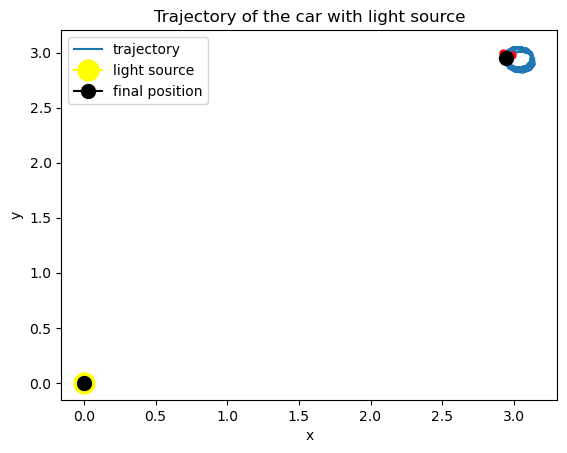

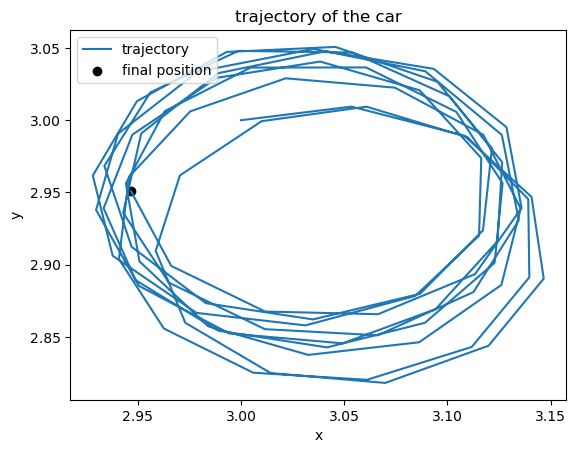

(2, 100) holds the (left sensor intensity, right sensor intensity)


In [61]:
agent=Braitenberg(starting_position, starting_bearing, genotype) #set up an agent with a random genotype
env=environment() #create the environment that the agent will run in
trajectory,intensities = env.run(runtime, agent,show=True)

# The trajectory variable hold the x, y coordinates
plt.plot(trajectory[0], trajectory[1], label="trajectory")
plt.scatter(trajectory[0][-1],trajectory[1][-1],color='black', label="final position")
plt.title("trajectory of the car")
plt.xlabel("x")
plt.ylabel("y")
# plt.legend([trajectory, final_position], ["trajectory", "final position"], loc="upper left")
plt.legend(loc="upper left")
plt.show()

print(intensities.shape,"holds the (left sensor intensity, right sensor intensity)")

In [62]:
# print(trajectory.shape, trajectory)

## Task 1 - Evolving a solution
Using the genetic algorithms you developed in lab 2, you will need to create your own fitness function. 

### 1.1 
Knowing that the 'env.run(params)' function returns all the x and y coordinates, you can find how far the agent has travelled and how close the agent gets to the target. 

Hint: You could use euclidean distance to calculate the start distance from the light source, to the end distance and gather the percentage of distance it has gained. 

Hint hint: Each trajectory should be closer and closer to the light. This means the more trajectorys that are closer to the light than the previous trajectory... the better. 

*count_of_trajectories_lower_than_prev/number_of_trajectories*



### 1.2 
Create a mutation function for the genotype. Make sure to think about copy by reference and by value. You can make use of the [deepcopy](https://docs.python.org/3/library/copy.html) function. Click the link to see the documentation.

It is worth noting that unlike in lab sheet 2 where you could switch your genes from 1 to 0 and 0 to 1, there are far more values involved in this. Consider using gaussian generated noise on top of a genotype.


```
genotype+=np.random.normal(mean, standard_d, size=genotype.shape)
```

You may want to limit the values that the genotype can reach. This stops the values from tending to too large or too small.

```
genotype[geotype > max_value] = max_value
genotype[geotype < min_value] = min_value
```



### 1.3 
Implement a Hill Climber that evolves your genotype

### 1.4
Implement the full Microbial GA

In [63]:
def euclid_dist(p1, p2):
  """
  Calculate the euclidean distance between pairs of points
  :return: distance of pooints
  """
  return np.sqrt(np.sum(np.square(p1 - p2), axis=-1))

#1.1
def fitness_function(positions,intensities,lightsource=(0,0)):
  # total_distance = euclid_dist(np.array((positions[0][0], positions[1][0])), np.array(lightsource))
  # cur_distance = euclid_dist(np.array((positions[0][-1], positions[1][-1])), np.array(lightsource))
  # # fitness = (total_distance-cur_distance)/total_distance+(intensities[0][-1]+intensities[1][-1]-intensities[0][0]-intensities[1][0])
  # fitness = (total_distance-cur_distance)/total_distance
  # # fitness = intensities[0][-1]+intensities[1][-1]-intensities[0][0]-intensities[1][0]

  # total_distance = euclid_dist(np.array((positions[0][0], positions[1][0])), np.array(lightsource))
  # fitness = sum([100000-euclid_dist(np.array((positions[0][i], positions[1][i])), np.array(lightsource)) for i in range(positions.shape[1])])
  fitness = 0
  pre_distance = euclid_dist(np.array((positions[0][0], positions[1][0])), np.array(lightsource))
  for i in range(1, len(positions[0])):
    distance = euclid_dist(np.array((positions[0][i], positions[1][i])), np.array(lightsource))
    fitness = fitness + pre_distance - distance
    # if distance < pre_distance:
    #   fitness += 1
    # else:
    #   fitness -= 1
    pre_distance = distance
  # fitness = sum(intensities[0])+sum(intensities[1])
  return fitness
#   pass
#1.2
def mutate(genotype, mutation_mean, mutation_std, min_value=0, max_value=5):
  mutated_genotype=deepcopy(genotype)
  # mutation_mean = np.mean(mutated_genotype)
  # mutation_std = np.std(mutated_genotype)
  mutated_genotype+=np.random.normal(mutation_mean, mutation_std, size=mutated_genotype.shape)
  mutated_genotype[mutated_genotype > max_value] = max_value
  mutated_genotype[mutated_genotype < min_value] = min_value
  return mutated_genotype
#   pass



In [64]:
# euclid_dist(np.array((1, 1)), np.array((0, 0)))

### FGA with crossover

In [78]:
def FGA(starting_position, starting_bearing, runtime, cross_rate, mutation_rate, mutation_mean, mutation_std, fitness, gene_pop, k):
  
  # prev_fitness = deepcopy(fitness)
  # prev_gene_pop = deepcopy(gene_pop)
  # starting_position = deepcopy(starting_position)
  # starting_bearing = deepcopy(starting_bearing)
  pop_size = len(fitness)
#   # se the starting position and the bearing
#   starting_position = (3,3)
#   starting_bearing = 10 #bearing in degrees
#   runtime = 5 #run to 5 seconds

  index_1 = int(np.random.rand()*len(gene_pop))
  local_neighbour_idx = np.random.randint(index_1+1, index_1 + k)
  if local_neighbour_idx >= pop_size:
    local_neighbour_idx = local_neighbour_idx % pop_size
  index_2 = local_neighbour_idx
  fitness1 = fitness[index_1]
  fitness2 = fitness[index_2]
  if fitness1 >= fitness2:
    winner = index_1
    loser = index_2
  else:
    winner = index_2
    loser = index_1
  for i in range(len(gene_pop[winner])):
    if np.random.random() < cross_rate:
      gene_pop[loser][i] = deepcopy(gene_pop[winner][i])

  if np.random.random() < mutation_rate:
    gene_pop[loser] = mutate(gene_pop[loser], mutation_mean, mutation_std)

  # for i in range(pop_size):
  #   if np.random.random() < mutation_rate:
  #     gene_pop[i] = mutate(gene_pop[i], mutation_mean, mutation_std)

  fitness1 = np.zeros(pop_size)
  fitness2 = np.zeros(pop_size)
  fitness3 = np.zeros(pop_size)
  fitness4 = np.zeros(pop_size)
  for i in range(pop_size):
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness1[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness2[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness3[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness4[i] = fitness_function(trajectory, intensities)
  fitness = np.mean((fitness1, fitness2, fitness3, fitness4), axis=0)

    # if fitness[i] != prev_fitness[i]:
    #   print("fitness changed")
    #   print(i, fitness[i], prev_fitness[i])
    #   print(gene_pop[i] == prev_gene_pop[i])

  # for i in range(pop_size): 
  #   if fitness[i] <= prev_fitness[i]: 
  #     gene_pop[i] = prev_gene_pop[i]
  #     fitness[i] = prev_fitness[i]

    #   agent=Braitenberg(starting_position, starting_bearing, prev_gene_pop[i]) #set up an agent with a random genotype
    #   env=environment() #create the environment that the agent will run in
    #   trajectory,intensities = env.run(runtime, agent, show=False)
    #   fitness[i] = fitness_function(trajectory, intensities)

  return fitness, gene_pop

In [85]:
import time

tic = time.time()

# se the starting position and the bearing
# starting_position = (3,3)
starting_position = (9,9)
starting_bearing = 10 #bearing in degrees
runtime = 15 #run to 5 seconds

num_epoch = 1000
cross_rate = 0.3
mutation_rate = 0.3
mutation_mean = 0
mutation_std = 4

pop_size = 30
k = pop_size//2

fitness_plot = []
gene_pop = np.random.rand(pop_size, 6)*5
fitness = np.zeros(pop_size)
for epoch in range(num_epoch):
  fitness, gene_pop = FGA(starting_position, starting_bearing, runtime, cross_rate, mutation_rate, mutation_mean, mutation_std, fitness, gene_pop, k)
  fitness_plot.append(max(fitness))
  # print(epoch, ":", np.argmax(fitness), max(fitness))
  # print(fitness)
  if epoch % 10 == 0:
    print(epoch, ":", np.argmax(fitness), max(fitness), "cost:", (time.time()-tic), "s")
  # if max(fitness) > 3000:
  #   break
print(np.argmax(fitness), max(fitness))
print(gene_pop[np.argmax(fitness)])
print(f"cost:{time.time()-tic}s")

0 : 4 0.631565169767736 cost: 2.078758716583252 s
10 : 13 0.6290200248552789 cost: 21.570257663726807 s
20 : 13 0.4456062871939763 cost: 41.038705587387085 s
30 : 4 0.6679981140688431 cost: 60.42767953872681 s
40 : 9 1.0837390735542356 cost: 80.00108194351196 s
50 : 6 3.8368696539450364 cost: 99.72429609298706 s
60 : 9 1.4538356276247448 cost: 119.29856848716736 s
70 : 6 1.5122686229086393 cost: 138.90242719650269 s
80 : 6 3.038097495728111 cost: 158.58266639709473 s
90 : 6 5.277119098041438 cost: 178.26330995559692 s
100 : 6 3.136831529995251 cost: 198.01864624023438 s
110 : 6 3.0474282906927517 cost: 218.0948145389557 s
120 : 9 1.1118882226401827 cost: 238.08362078666687 s
130 : 6 3.0367543572256066 cost: 258.1881248950958 s
140 : 6 2.2722608090366583 cost: 278.08176159858704 s
150 : 6 4.145289416549868 cost: 298.0548629760742 s
160 : 26 0.8267540710899377 cost: 317.93570041656494 s
170 : 9 0.7668286957890085 cost: 338.0029652118683 s
180 : 26 0.6739898476612152 cost: 357.98498845100

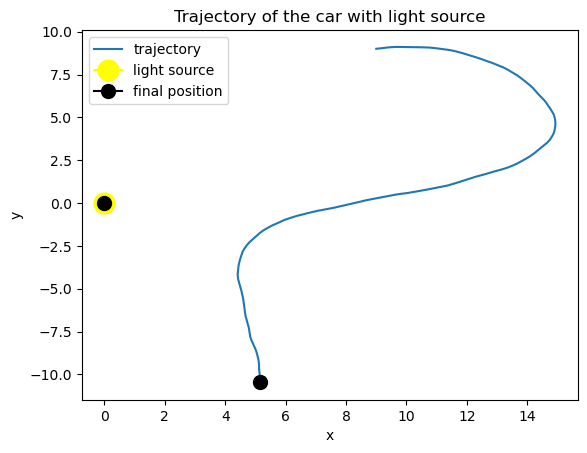

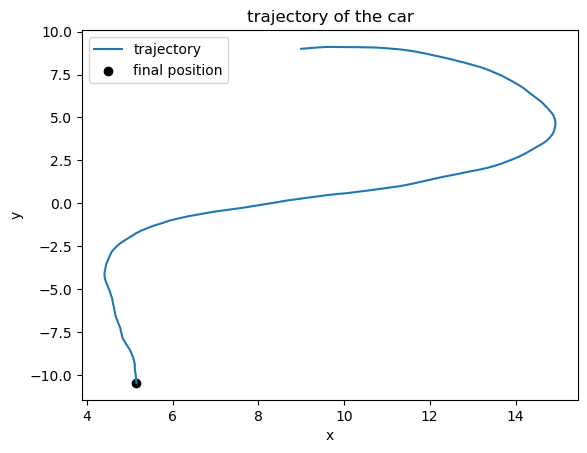

(2, 300) holds the (left sensor intensity, right sensor intensity)


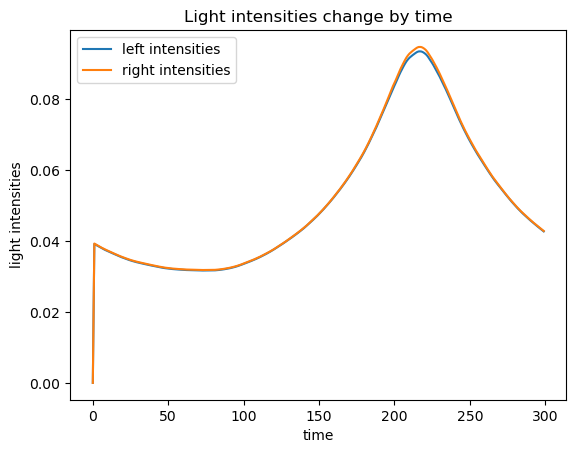

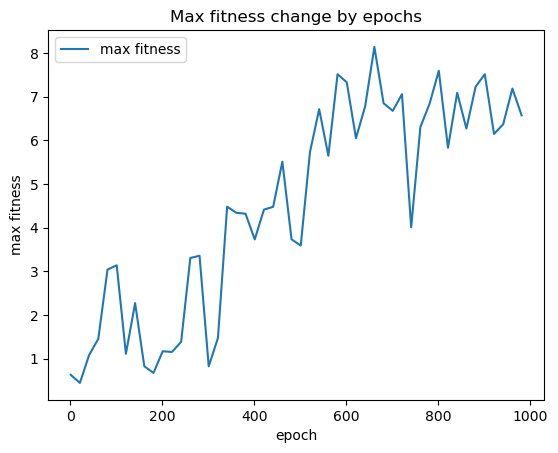

5.156035808791173 -10.465234242603328
[2.25673062 4.38163187 0.         0.         3.86087355 3.72141862]
20 8.997467225817243
[0.631565169767736, 0.6759550356426463, 0.928403917444435, 0.5229554737224067, 0.3942025443078383, 0.3721962003509858, 0.9217352063065536, 0.6035047123176223, 0.6857484360304418, 0.4398568647959258, 0.6290200248552789, 0.9871580129759563, 0.9242872374491959, 0.564239534902153, 0.6137763722847143, 0.6349472642632779, 0.6200981585766399, 0.5166356026388192, 0.6167096040979292, 0.417194407024017, 0.4456062871939763, 0.5907670656508777, 0.5794613524702839, 0.7145787252795279, 0.715854099647828, 0.7806950433959003, 0.8396227079062544, 0.7294739697127564, 0.8670627230076455, 0.7223651169973291, 0.6679981140688431, 0.8099188509758428, 0.5823134101654497, 0.7850860753191178, 0.6316761350388584, 0.5585298846882365, 0.5802754320356747, 0.6263173509332658, 1.2797079886068023, 0.9969065634005556, 1.0837390735542356, 0.7666786410077813, 0.9909617034198619, 0.561091331358942

In [91]:
# # se the starting position and the bearing
# starting_position = (3,3)
# starting_bearing = 10 #bearing in degrees
# runtime = 5 #run to 5 seconds

agent=Braitenberg(starting_position, starting_bearing, gene_pop[np.argmax(fitness)]) #set up an agent with a random genotype
env=environment() #create the environment that the agent will run in
trajectory,intensities = env.run(runtime, agent,show=True)

# The trajectory variable hold the x, y coordinates
plt.plot(trajectory[0], trajectory[1], label="trajectory")
plt.scatter(trajectory[0][-1],trajectory[1][-1],color='black', label="final position")
plt.title("trajectory of the car")
plt.xlabel("x")
plt.ylabel("y")
# plt.legend([trajectory, final_position], ["trajectory", "final position"], loc="upper left")
plt.legend(loc="upper left")
plt.show()

print(intensities.shape,"holds the (left sensor intensity, right sensor intensity)")
plt.plot(range(len(intensities[0])), intensities[0], label="left intensities")
plt.plot(range(len(intensities[1])), intensities[1], label="right intensities")
plt.title("Light intensities change by time")
plt.xlabel("time")
plt.ylabel("light intensities")
plt.legend(loc="upper left")
plt.show()

step = 20
plt.plot(range(1, num_epoch+1, step), fitness_plot[::step], label="max fitness")
plt.title("Max fitness change by epochs")
plt.xlabel("epoch")
plt.ylabel("max fitness")
plt.legend(loc="upper left")
plt.show()

print(trajectory[0][-1],trajectory[1][-1])
print(gene_pop[np.argmax(fitness)])
print(np.argmax(fitness), max(fitness))

print(fitness_plot)

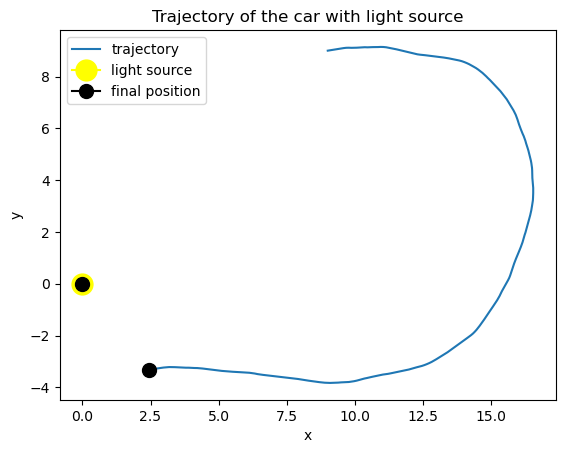

8.603460624781288 8.997467225817243


In [90]:
agent=Braitenberg(starting_position, starting_bearing, gene_pop[np.argmax(fitness)]) #set up an agent with a random genotype
env=environment() #create the environment that the agent will run in
trajectory,intensities = env.run(runtime, agent,show=True)
fitness_best = fitness_function(trajectory, intensities)
print(fitness_best, max(fitness))

### FGA without crossover

In [ ]:
def FGA_without_crossover(starting_position, starting_bearing, runtime, cross_rate, mutation_rate, mutation_mean, mutation_std, fitness, gene_pop, k):
  
  # prev_fitness = deepcopy(fitness)
  # prev_gene_pop = deepcopy(gene_pop)
  # starting_position = deepcopy(starting_position)
  # starting_bearing = deepcopy(starting_bearing)
  pop_size = len(fitness)
#   # se the starting position and the bearing
#   starting_position = (3,3)
#   starting_bearing = 10 #bearing in degrees
#   runtime = 5 #run to 5 seconds

  index_1 = int(np.random.rand()*len(gene_pop))
  local_neighbour_idx = np.random.randint(index_1+1, index_1 + k)
  if local_neighbour_idx >= pop_size:
    local_neighbour_idx = local_neighbour_idx % pop_size
  index_2 = local_neighbour_idx
  fitness1 = fitness[index_1]
  fitness2 = fitness[index_2]
  if fitness1 >= fitness2:
    winner = index_1
    loser = index_2
  else:
    winner = index_2
    loser = index_1
#   for i in range(len(gene_pop[winner])):
#     if np.random.random() < cross_rate:
#       gene_pop[loser][i] = deepcopy(gene_pop[winner][i])

  if np.random.random() < mutation_rate:
    gene_pop[loser] = mutate(gene_pop[loser], mutation_mean, mutation_std)

  # for i in range(pop_size):
  #   if np.random.random() < mutation_rate:
  #     gene_pop[i] = mutate(gene_pop[i], mutation_mean, mutation_std)

  fitness1 = np.zeros(pop_size)
  fitness2 = np.zeros(pop_size)
  fitness3 = np.zeros(pop_size)
  fitness4 = np.zeros(pop_size)
  for i in range(pop_size):
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness1[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness2[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness3[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i]) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness4[i] = fitness_function(trajectory, intensities)
  fitness = np.mean((fitness1, fitness2, fitness3, fitness4), axis=0)

    # if fitness[i] != prev_fitness[i]:
    #   print("fitness changed")
    #   print(i, fitness[i], prev_fitness[i])
    #   print(gene_pop[i] == prev_gene_pop[i])

  # for i in range(pop_size): 
  #   if fitness[i] <= prev_fitness[i]: 
  #     gene_pop[i] = prev_gene_pop[i]
  #     fitness[i] = prev_fitness[i]

    #   agent=Braitenberg(starting_position, starting_bearing, prev_gene_pop[i]) #set up an agent with a random genotype
    #   env=environment() #create the environment that the agent will run in
    #   trajectory,intensities = env.run(runtime, agent, show=False)
    #   fitness[i] = fitness_function(trajectory, intensities)

  return fitness, gene_pop

In [ ]:
# # se the starting position and the bearing
# starting_position = (3,3)
# starting_bearing = 10 #bearing in degrees
# runtime = 5 #run to 5 seconds

agent=Braitenberg(starting_position, starting_bearing, gene_pop[np.argmax(fitness)]) #set up an agent with a random genotype
env=environment() #create the environment that the agent will run in
trajectory,intensities = env.run(runtime, agent,show=True)

# The trajectory variable hold the x, y coordinates
plt.plot(trajectory[0], trajectory[1], label="trajectory")
plt.scatter(trajectory[0][-1],trajectory[1][-1],color='black', label="final position")
plt.title("trajectory of the car")
plt.xlabel("x")
plt.ylabel("y")
# plt.legend([trajectory, final_position], ["trajectory", "final position"], loc="upper left")
plt.legend(loc="upper left")
plt.show()

print(intensities.shape,"holds the (left sensor intensity, right sensor intensity)")
plt.plot(range(len(intensities[0])), intensities[0], label="left intensities")
plt.plot(range(len(intensities[1])), intensities[1], label="right intensities")
plt.title("Light intensities change by time")
plt.xlabel("time")
plt.ylabel("light intensities")
plt.legend(loc="upper left")
plt.show()

step = 20
plt.plot(range(1, num_epoch+1, step), fitness_plot[::step], label="max fitness")
plt.title("Max fitness change by epochs")
plt.xlabel("epoch")
plt.ylabel("max fitness")
plt.legend(loc="upper left")
plt.show()

print(trajectory[0][-1],trajectory[1][-1])
print(gene_pop[np.argmax(fitness)])
print(np.argmax(fitness), max(fitness))

print(fitness_plot)

In [ ]:
agent=Braitenberg(starting_position, starting_bearing, gene_pop[np.argmax(fitness)]) #set up an agent with a random genotype
env=environment() #create the environment that the agent will run in
trajectory,intensities = env.run(runtime, agent,show=True)
fitness_best = fitness_function(trajectory, intensities)
print(fitness_best, max(fitness))

## Task 2 - Tweaking the parameters

### 2.1
Change the noise with the simulation. The world is noisy and makes it harder for an agent to adapt to an environment. Experiment with noise in the simulation and see how this affects your accuracies against the less noisy simulations. Does more noise affect accuracy? Is the difference insignificant? 

`environment(sig=0.1) `
Changes the noise levels


### 2.2 (Optional)
Experiment with different genotype sizes. The lines 


```
w_ll,w_lr,w_rl,w_rr,bl,br = agent.get_geno()
```



```
#weights times inputs plus bias
lm = il*w_ll + ir*w_rl + bl;
rm = il*w_lr + ir*w_rr + br;
```

Both in the environment class, these encode the values that we move the motors by. Try having a larger genotype, think about network architecture to how many you will need. If you added a hidden layer of three nodes, you would need 6 weights from the inputs and 6 weights to the output. Then 5 optional biases. 

If you are stuck with this one, here is some code that you can add to your environment class. It allows you to enter network layer sizes, and it will tell you how large your genotype should be, and what indicies will need to be broken up. eg [0:8] (input weights), [8:12] (biases), [12:20] (output weights) for a genotype for a network of 2 inputs, 4 hidden nodes, 4 biases and 2 outputs.



```
def gen_geno_size(self,layers=[4]):
    layers.append(2) #add the output layers
    #given an array of layer sizes eg [2,3,4] calculate the idxs of the genotype and layer size
    ids=[]
    ids.append(2*layers[0])#weights for input layers
    ids.append(2*layers[0]+ layers[0])#bias for input layers
    last=ids[-1]
    for i in range(1,len(layers)): #loop through hidden and output
      layer=layers[i]
      ids.append(last+ layers[i-1]*layer) #weight matrix
      ids.append(last+ layers[i-1]*layer + layer) #bias matrix
      last=ids[-1] #last point in array
    return sum(ids),ids
```

You will need to generate a genotype of size `sum(ids)` and generate the weight matrices and bias matrices using the genotype data. 


We can then replace the part of the code that performs the left and right multiplication with the multiplication through the layers:



```
#  Calculate local intensity
il = np.array(sensor_gain/dl)
ir = np.array(sensor_gain/dr)
#weights times inputs plus bias

m=np.array([il,ir]).T #initial inputs
for i in range(0,len(weights)):
   m = np.dot(m,weights[i]) + biases[i] #caclulation through network
#get output values
lm=m[0][0]
rm=m[0][1]
```







In [53]:
def gen_geno_size(layers=[4]):
  layers=deepcopy(layers)
  layers.append(2) #add the output layers
  #given an array of layer sizes eg [2,3,4] calculate the idxs of the genotype and layer size
  ids=[]
  ids.append(2*layers[0])#weights for input layers
  ids.append(2*layers[0]+ layers[0])#bias for input layers
  last=ids[-1]
  for i in range(1,len(layers)): #loop through hidden and output
    layer=layers[i]
    ids.append(last+ layers[i-1]*layer) #weight matrix
    ids.append(last+ layers[i-1]*layer + layer) #bias matrix
    last=ids[-1] #last point in array
  return max(ids),ids

In [54]:
class Braitenberg:
  """
  This class holds the genotype and position of the braigtenberg vihicle 
  """
  def __init__(self,initial_pos,initial_bearing,geno, layers=[]):
    #@ param initial_pos is the starting pos
    #@ param initial_bearing is the starting direction of the board (degrees) e.g 45
    #@ param geno is the genotype to encode hardware e.g [w_ll w_lr w_rl w_rr bl br] encoded as 1 or 0
    self.geno=geno
    self.layers = layers
    #assert (type(self.geno)==type([]) or type(self.geno)==type(np.array([]))) and len(self.geno)==6,"Genotype must be an array of size 6"
    self.initial_bearing = initial_bearing
    self.pos=initial_pos

  def get_geno(self):
    #@ returns the genotype options
    return self.geno
  
  def get_params(self): 
    size, ids = gen_geno_size(self.layers)
    layers = deepcopy(self.layers)
    layers = [2] + layers
    layers.append(2)
    weights = []
    bias = []
    for index, id in enumerate(ids):
      if index % 2 == 0:
        if index == 0:
          # print(index, 0, id, layers[(index//2)+1], layers[index//2])
          weights.append(self.geno[:id].reshape(layers[(index//2)], layers[(index//2)+1]))
          # print(geno[:id].reshape(layers[(index//2)+1], layers[index//2]))
        else:
          # print(index, ids[index-1], id, layers[(index//2)+1], layers[index//2])
          weights.append(self.geno[ids[index-1]:id].reshape(layers[(index//2)], layers[(index//2)+1]))
          # print(geno[ids[index-1]:id].reshape(layers[(index//2)+1], layers[index//2]))
      else: 
        # print(index, ids[index-1], id, layers[(index//2)+1], 1)
        bias.append(self.geno[ids[index-1]: id].reshape(1, layers[(index//2)+1]))
        # print(geno[ids[index-1]: id].reshape(layers[(index//2)+1], 1))
    return weights, bias

class environment:
  """
  allows running of a trial in a set up environment
  """
  def __init__(self, sig=0.1):
    # Initial setup
    self.dt=0.05;
    self.R =0.05; #radius
    self.b = 45; #(degrees) sensor anglr
    self.sig = sig

  def run(self,T,agent,motor_gain=0.5,show=True,S=(0,0)):
    #@ param T is the time it will run for
    #@ param agent is the braitenberg vehicle object used
    #@ param show is whether it will show the plot
    #@ returns 2D array of positions the agent has traveleld through [[x],[y]]
    #conver geno params
    if len(agent.layers):
      weights, biases = agent.get_params()
    else:
      w_ll,w_lr,w_rl,w_rr,bl,br = agent.get_geno()
    sl_pos = np.zeros((2,1));
    sr_pos = np.zeros((2,1));
    S=np.array(S)
    rho=np.zeros((2, 1));
    sensor_gain = 0.5;
    motor_gain =motor_gain;
    vl=0;vr=0;
    #convert to radians
                                                
    initial_bearing = agent.initial_bearing/360*2*np.pi;
    b=self.b/360*2*np.pi;
    
    pos = np.zeros((2,int(T/self.dt)));
    bearing = np.zeros((1,int(T/self.dt)));
    pos[:,0] = agent.pos;
    bearing[:,0] = initial_bearing;
    lightIntensity=np.zeros((2,int(T/self.dt)));
   
    for i in range(1, int(T/self.dt)):
        vc = (vl+vr)/2;
        va = (vr-vl)/(2*self.R);
        pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
        pos[1,i] = pos[1,i-1]+ self.dt*vc*np.sin(bearing[0,i-1]);
        bearing[0,i] = np.mod(bearing[0,i-1] + self.dt*va,2*np.pi);
        
        # Calculate left sensor position
        sl_pos[0] = pos[0,i] + self.R*np.cos(bearing[0,i]+b);
        sl_pos[1] = pos[1,i] + self.R*np.sin(bearing[0,i]+b);
        
        # Calculate right sensor position
        sr_pos[0] = pos[0,i] + self.R*np.cos(bearing[0,i]-b);
        sr_pos[1] = pos[1,i] + self.R*np.sin(bearing[0,i]-b);
    
        # Calculate (square) distance to element
        #this code assumes light is always at S
        dl = np.sqrt((sl_pos[0]-S[0])**2+(sl_pos[1]-S[1])**2);
        dr = np.sqrt((sr_pos[0]-S[0])**2+(sr_pos[1]-S[1])**2);
        if len(agent.layers): 
          #  Calculate local intensity
          il = np.array(sensor_gain/dl)
          ir = np.array(sensor_gain/dr)
          # weights times inputs plus bias
          m=np.array([il,ir]).T #initial inputs
          # print(m.shape)
          for i in range(0,len(weights)):
            m = np.dot(m, weights[i]) + biases[i] #caclulation through network
          # get output values
          lm=m[0][0]
          rm=m[0][1]
          # print(m.shape, m, lm, rm)
        else: 
          #  Calculate local intensity
          il = sensor_gain/dl;
          ir = sensor_gain/dr;
          lightIntensity[0,i] = il
          lightIntensity[1,i] = ir
          #weights times inputs plus bias
          lm = il*w_ll + ir*w_rl + bl;
          rm = il*w_lr + ir*w_rr + br;


        # add a some gaussian noise to ech motor. 
        # The sig variable controls how much noise is added
        lm = lm + np.random.normal(0, self.sig)
        rm = rm + np.random.normal(0, self.sig)

        #  Scale by motor gains
        vl =motor_gain*lm;
        vr =motor_gain*rm;
    if show:
      self.show(T,pos,sl_pos,sr_pos,bearing,b)
    return pos,lightIntensity
  def show(self,T,pos,sl_pos,sr_pos,bearing,b):
    plt.plot(pos[0,:],pos[1,:], label="trajectory")       
    #final postion
    x=pos[0,int(T/self.dt)-1];
    y= pos[1,int(T/self.dt)-1];
    f_bearing = bearing[0,int(T/self.dt)-1];
    # Calculate left sensor position
    sl_pos[0] = x + self.R*np.cos(f_bearing+b);
    sl_pos[1] = y + self.R*np.sin(f_bearing+b);
    # Calculate left sensor position
    sr_pos[0] = x + self.R*np.cos(f_bearing-b);
    sr_pos[1] = y + self.R*np.sin(f_bearing-b);
   
    plt.plot(0,0,marker='.',markersize=30,color='yellow', label="light source");
    plt.plot(0,0,marker='o',markersize=10,color='black');
       
    # Plot  sensors
    #
    plt.plot(sl_pos[0],sl_pos[1],marker='.',markersize=10,color='red');
    plt.plot(sr_pos[0],sr_pos[1],marker='.',markersize=10,color='red');
 
    # Plot body
    plt.plot(x, y,marker='.',markersize=10,color='blue');
    plt.plot(x,y,marker='o',markersize=10,color='black', label="final position");
    
    plt.title("Trajectory of the car with light source")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc="upper left")
    # plt.legend(["trajectory", "light source", "light source", "left sensor", "right sensor", "final position", "final position"], loc="upper left")
    #Plot trajkectory
    plt.pause(0.05)
    
    return pos

In [55]:
def FGA(starting_position, starting_bearing, runtime, cross_rate, mutation_rate, mutation_mean, mutation_std, fitness, gene_pop, k, layers):
  
  # prev_fitness = deepcopy(fitness)
  # prev_gene_pop = deepcopy(gene_pop)
  pop_size = len(fitness)
#   # se the starting position and the bearing
#   starting_position = (3,3)
#   starting_bearing = 10 #bearing in degrees
#   runtime = 5 #run to 5 seconds

  index_1 = int(np.random.rand()*len(gene_pop))
  local_neighbour_idx = np.random.randint(3+1, 3 + k)
  if local_neighbour_idx >= pop_size:
    local_neighbour_idx = local_neighbour_idx % pop_size
  index_2 = local_neighbour_idx
  fitness1 = fitness[index_1]
  fitness2 = fitness[index_2]
  if fitness1 >= fitness2:
    winner = index_1
    loser = index_2
  else:
    winner = index_2
    loser = index_1
  for i in range(len(gene_pop[winner])):
    if np.random.random() < cross_rate:
      gene_pop[loser][i] = deepcopy(gene_pop[winner][i])
  
  if np.random.random() < mutation_rate:
    gene_pop[loser] = mutate(gene_pop[loser], mutation_mean, mutation_std)

  for i in range(pop_size):
    if np.random.random() < mutation_rate:
      gene_pop[i] = mutate(gene_pop[i], mutation_mean, mutation_std)

  fitness1 = np.zeros(pop_size)
  fitness2 = np.zeros(pop_size)
  fitness3 = np.zeros(pop_size)
  fitness4 = np.zeros(pop_size)
  for i in range(pop_size):
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i], layers) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness1[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i], layers) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness2[i] = fitness_function(trajectory, intensities)
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i], layers) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness3[i] = fitness_function(trajectory, intensities)  
    agent=Braitenberg(starting_position, starting_bearing, gene_pop[i], layers) #set up an agent with a random genotype
    env=environment() #create the environment that the agent will run in
    trajectory,intensities = env.run(runtime, agent, show=False)
    fitness4[i] = fitness_function(trajectory, intensities)
  fitness = np.mean((fitness1, fitness2, fitness3, fitness4), axis=0)

  # for i in range(pop_size): 
  #   if fitness[i] <= prev_fitness[i]: 
  #     gene_pop[i] = prev_gene_pop[i]
  #     fitness[i] = prev_fitness[i]

    #   agent=Braitenberg(starting_position, starting_bearing, prev_gene_pop[i]) #set up an agent with a random genotype
    #   env=environment() #create the environment that the agent will run in
    #   trajectory,intensities = env.run(runtime, agent, show=False)
    #   fitness[i] = fitness_function(trajectory, intensities)

  return fitness, gene_pop

In [49]:
import time

tic = time.time()

# se the starting position and the bearing
starting_position = (3,3)
starting_bearing = 10 #bearing in degrees
runtime = 5 #run to 5 seconds

layers=[4]

num_epoch = 2000
cross_rate = 0.7
mutation_rate = 0.7
mutation_mean = 0
mutation_std = 2

pop_size = 30
k = pop_size//2

fitness_plot = []

if len(layers): 
  size, ids = gen_geno_size(layers)
  gene_pop = np.random.rand(pop_size, size)
else:
  gene_pop = np.random.rand(pop_size, 6)*5
fitness = np.zeros(pop_size)
for epoch in range(num_epoch):
  fitness, gene_pop = FGA(starting_position, starting_bearing, runtime, cross_rate, mutation_rate, mutation_mean, mutation_std, fitness, gene_pop, k, layers)
  fitness_plot.append(max(fitness))
  if epoch % 10 == 0:
    print(epoch, ":", np.argmax(fitness), max(fitness), "cost:", (time.time()-tic), "s")

print(np.argmax(fitness), max(fitness))
print(gene_pop[np.argmax(fitness)])
print(Braitenberg(starting_position, starting_bearing, gene_pop[np.argmax(fitness)], layers).get_params())
print(f"cost:{time.time()-tic}s")

0 : 4 1.6720765379696192 cost: 0.517615795135498 s
10 : 10 3.114366935753857 cost: 5.678808689117432 s
20 : 1 2.8833245776174348 cost: 10.93175482749939 s
30 : 22 3.025951654573161 cost: 16.14480996131897 s
40 : 5 3.293297112764779 cost: 21.478081464767456 s
50 : 12 2.917032499339842 cost: 26.79473090171814 s
60 : 39 3.1237616678710887 cost: 31.9677791595459 s
70 : 42 2.9488763269715674 cost: 36.969210624694824 s
80 : 4 2.4183384235594136 cost: 42.21048974990845 s
90 : 2 3.025959536107898 cost: 47.409610748291016 s
100 : 25 3.046321249239811 cost: 52.848740339279175 s
110 : 34 3.204483597187042 cost: 58.003387689590454 s
120 : 1 3.6798406901036045 cost: 63.01139235496521 s
130 : 7 2.299470233635456 cost: 67.95644760131836 s
140 : 2 3.0219285175755433 cost: 73.68335509300232 s
150 : 13 3.038724902157444 cost: 79.18478870391846 s
160 : 20 3.204542888473223 cost: 84.5315911769867 s
170 : 45 3.8206109250321183 cost: 89.62916398048401 s
180 : 9 2.397062288221243 cost: 95.57469892501831 s
19

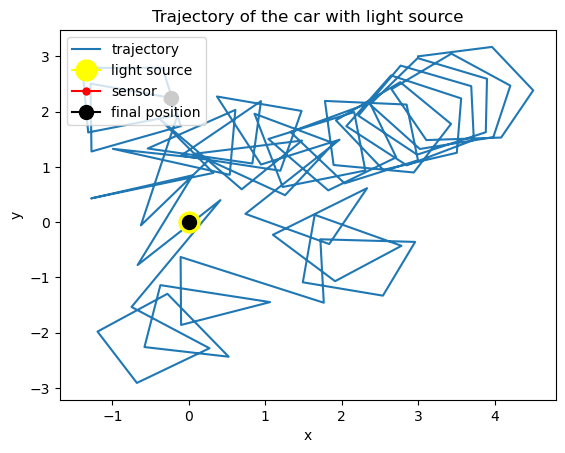

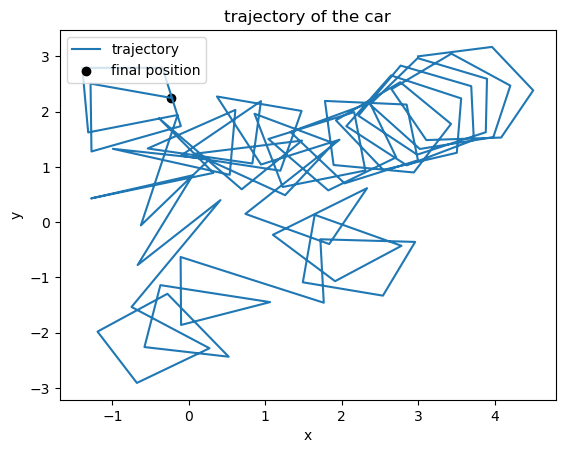

(2, 100) holds the (left sensor intensity, right sensor intensity)


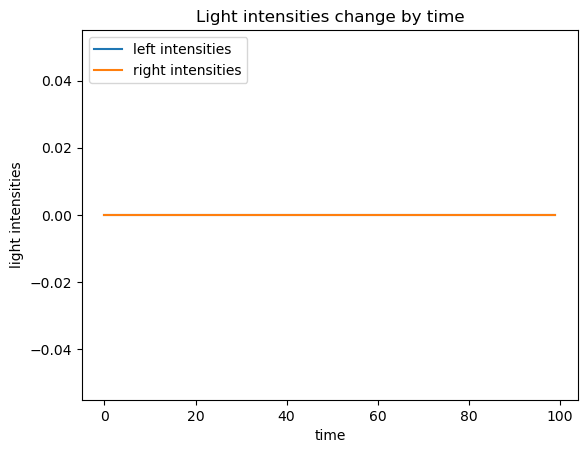

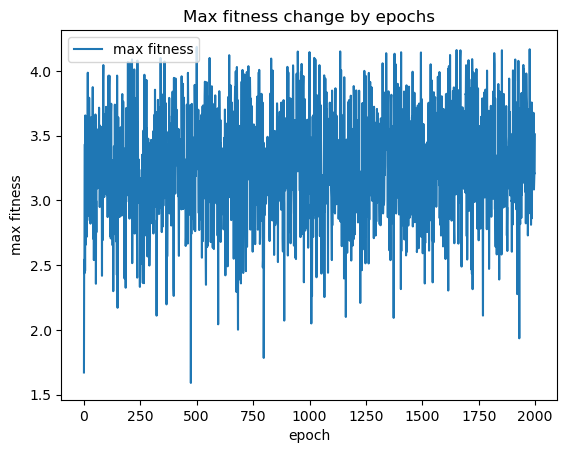

-0.23900277754148425 2.249904012928848
[5.         5.         0.33337895 2.3408444  0.         2.49233389
 0.         1.92894217 5.         2.21004551 2.52208142 0.
 2.6459631  0.8405278  5.         5.         2.32721907 5.
 5.         2.60942244 2.94602083 2.69047377]
31 3.5098234203334115
[1.6720765379696192, 2.5419686077159196, 2.4373591284899825, 3.019465457584176, 3.433729414712624, 2.4564362027828075, 3.6556219855869236, 2.655888077193537, 2.9509463799041384, 3.3152677139705315, 3.114366935753857, 3.2088211254002132, 2.718534650218881, 3.0794211336367177, 3.6263396065693314, 3.495897725486502, 3.315993356855917, 3.9853897079877583, 3.035406434935565, 3.577507276577843, 2.8833245776174348, 3.4123470403969627, 2.905100979187802, 3.792073050860976, 3.5631138441936185, 2.922787121293541, 2.844457970873832, 3.076565847363187, 3.0942370313798264, 2.820652456381922, 3.025951654573161, 3.3020873040404126, 3.49068175727949, 3.6431236623668406, 3.4369856931722538, 3.587667384950925, 2.9477

In [50]:
agent=Braitenberg(starting_position, starting_bearing, gene_pop[np.argmax(fitness)], layers) #set up an agent with a random genotype
env=environment() #create the environment that the agent will run in
trajectory,intensities = env.run(runtime, agent,show=True)

# The trajectory variable hold the x, y coordinates
plt.plot(trajectory[0], trajectory[1], label="trajectory")
plt.scatter(trajectory[0][-1],trajectory[1][-1],color='black', label="final position")
plt.title("trajectory of the car")
plt.xlabel("x")
plt.ylabel("y")
# plt.legend([trajectory, final_position], ["trajectory", "final position"], loc="upper left")
plt.legend(loc="upper left")
plt.show()

print(intensities.shape,"holds the (left sensor intensity, right sensor intensity)")
# print(intensities)
plt.plot(range(len(intensities[0])), intensities[0], label="left intensities")
plt.plot(range(len(intensities[1])), intensities[1], label="right intensities")
plt.title("Light intensities change by time")
plt.xlabel("time")
plt.ylabel("light intensities")
plt.legend(loc="upper left")
plt.show()

plt.plot(range(num_epoch), fitness_plot, label="max fitness")
plt.title("Max fitness change by epochs")
plt.xlabel("epoch")
plt.ylabel("max fitness")
plt.legend(loc="upper left")
plt.show()

print(trajectory[0][-1],trajectory[1][-1])
print(gene_pop[np.argmax(fitness)])
print(np.argmax(fitness), max(fitness))

print(fitness_plot)

# Physical robot

The physical robot makes use of light sensors and two motors. Like the simulation, we can encode this information of what to use and what not to use into the physical robot. 

<img src="https://raw.githubusercontent.com/shepai/OpenEduBot/main/Assets/wheelBot.jpg" width="25%" >

We can attach a USB to it and upload the agent code with the trained genotype. You can also edit this code to improve the noise reduction. 

The following code will not work in colab as it needs to pass across the serial ports, and the local serial ports for your colab file is a google server somewhere else in the world! 



## Using a different IDE
Using a different IDE can be simpler for using MicroPython. [Thonny IDE](https://thonny.org/) is a simple IDE for uploading programs to the Raspberry Pi Pico. Once you have set up the IDE we can start [programming the board](https://projects.raspberrypi.org/en/projects/getting-started-with-the-pico).

### Step 1
Download the robot control library from [Github](https://raw.githubusercontent.com/shepai/OpenEduBot/main/Library/EduBot.py) and have handy in a folder. 

### Step 2
You will need to connect the robot to your device via USB. Make sure you have Thonny IDE up. In the bottom right corner you should be able to select the interpreter for the IDE. We want Raspberry Pi Pico MicroPython.

<img src="https://projects-static.raspberrypi.org/projects/getting-started-with-the-pico/725a421f3b51a5674c539d6953db5f1892509475/en/images/thonny-micropython-pico-menu.png" width="35%" >

The software will ask you to install firmware for the Pico. Install it.

<img src="https://projects-static.raspberrypi.org/projects/getting-started-with-the-pico/725a421f3b51a5674c539d6953db5f1892509475/en/images/thonny-install-micropython-pico.png" width="35%" >

The shell should then show it is connected to the Pico. Try entering the following in the shell:

```
print("Hello, world!")
```

This code is compiling on the Pico board. Any code they you write and run will now be uploading to the device. 


### Step 3
Open the downloaded EduBot.py in the Thonny IDE, and then go to File>Save As and a prompt will come up asking whether to install on the device or computer. Resave the file on the device with the same name. We do this so we can control the chassis hardware.

### Step 4
Within this colab folder save the genotypes that you wish to upload to the board. These can be saved directly on the device as well, or can be copied across manually into the code with copy and paste. 
```
np.save("path/to/file",best_genotype)
```

## Using the robot

### Dependencies

- CircuitPython
All can be found under the (adafruit circuitpython library bundle)[https://circuitpython.org/libraries]
    1. simpleio
    2. adafruit_motor


## CircuitPython
CircuitPython is an open-source derivative of the MicroPython programming language targeted toward students and beginners.

```
from EduBot_CP import wheelBot

bot = wheelBot()
```

Using CircuitPython with the Pico and robotics hat you will need to use:

```
from EduBot_CP import wheelBot

bot = wheelBot(board_type="pico")
```

In order for it to work with the Pico and motor driver board, you must add the following parameter.
```
from EduBot_CP import wheelBot

bot = wheelBot(board_type="pico_1")
```

## MicroPython
MicroPython is the default variant of python electronics on the Raspberry Pi Pico. The library has been developed for many chassis.

```
from EduBot import wheelBot

bot = wheelBot()
```
In order for it to work with the Pico and robotics board, you must add the following parameter.
```
from EduBot import wheelBot

bot = wheelBot(board_type="pico")
```
In order for it to work with the Pico and (Kitroniks motor driver board)[https://thepihut.com/products/motor-driver-board-for-raspberry-pi-pico], you must add the following parameter.
```
from EduBot import wheelBot

bot = wheelBot(board_type="pico_1")




We need to download the robot control library and upload it to the board.

In [17]:
!wget https://raw.githubusercontent.com/shepai/OpenEduBot/main/Library/EduBot.py

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


#Sim2Real

The following is the code that is needed on board, which will need to be copied across and saved as main.py

In [18]:
"""
Braightenberg robot for crossing the reality gap
The light sensors allow light following behaviours.

The sensor pins are read at 26 and 27, if the robot is not turning away from the collision,
consider switching the pins around (26 & 27).

Code by Dexter R Shepherd

"""

from EduBot import wheelBot_2
import utime
from machine import ADC

#a=wheelBot_2()
sensor1=ADC(26)
sensor2=ADC(27)

#change the sensor gain to preference
sensor_gain=0.5

def calc(genotype):
    w_ll,w_lr,w_rl,w_rr,bl,br = (genotype[0],genotype[1],genotype[2],genotype[3],genotype[4],genotype[5])
    # Calculate (square) distance to element
    dl=int(sensor1.read_u16()/1000)
    dr=int(sensor2.read_u16()/1000)

    #  Calculate local intensity
    il = sensor_gain/dl;
    ir = sensor_gain/dr;
    #weights times inputs plus bias
    lm = il*w_ll + ir*w_rl + bl;
    rm = il*w_lr + ir*w_rr + br;
    print(">",dl,dr)
    print(lm,rm)
    return lm,rm

calc([1.03225166, 0, 0, 5, 5, 4.13412594])


ModuleNotFoundError: No module named 'machine'

## Task 3 - Crossing the reality gap

This task is about finding unique solutions to improving the crossing of the reality gap

### 3.1 

**Either**

Upload your best genotypes to the robot and watch the behaviours, what do you notice about the agent compared to simulation?

Attempt to play around with sensor_gain, using a physical screw to change the threshold of sensitivity on the sensors, and any other hyperparameters you can think of.

**Or**

Try manually code a braitenberg robot on the robot. Are there algorithms or behaviours that worked well in simulation that you want?

### 3.2 (optional) 
Play around with the source code that is being uploaded. Perhaps add noise to the sensors, or more sensors? 